# STC Supplementary Figure

TODO: Integrate with preprocessing/plotting notebook for final version

In [1]:
import pathlib
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


import cmocean.cm as cmo
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar

from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.postprocessing import concat_members, concat_experiments

from xarrayutils.utils import linear_trend, xr_linregress
from xarrayutils.utils import sign_agreement
from xarrayutils.filtering import filter_2D
from xarrayutils.plotting import shaded_line_plot, map_util_plot

from cmip6_omz.units import convert_mol_m3_mymol_kg
from cmip6_omz.omz_tools import mask_basin
from cmip6_omz.upstream_stash import zarr_exists

from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend, mask_multi_model
from busecke_etal_2021_aguadv.utils import load_zarr_directory

from xhistogram.xarray import histogram

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [54]:
pfolder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/notebooks/plots_revision/')

In [23]:
# load histogram data
fail_age_models = ['MRI-ESM2-0','MPI-ESM1-2-HR','MPI-ESM1-2-LR'] # These are the ones I will not use

# TODO: replace this with just one folder once v2.3 is done
# Then also convert this to a dict and just use `load_zarr_directory
dfolder = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.3/'
ddict_histogram = load_zarr_directory(dfolder)
# remove obs
del ddict_histogram['none.none.none.none.none.none.none.none.none']
ddict_histogram = concat_members(ddict_histogram)
# simple renaming
ddict_histogram = {k.split('.')[0]:ds for k,ds in ddict_histogram.items()}

In [24]:
from busecke_etal_2021_aguadv.utils import stci

In [19]:
# Load the STC data
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed/pacific_meridional_overturning_filtered/'
flist = list(pathlib.Path(path).glob('*.nc'))
ddict_psi = {}
for f in flist:
    source_id, experiment_id = tuple(f.stem.replace('temp_','').replace('.nc','').split('_'))
    ds = xr.open_dataset(f, use_cftime=True)
    ds.attrs['source_id'] = source_id
    ds.attrs['experiment_id'] = experiment_id
    ddict_psi[f"{source_id}.{experiment_id}"] = ds
ddict_psi = concat_experiments(ddict_psi, concat_kwargs={'combine_attrs': 'drop_conflicts', 'compat': 'override', 'coords': 'minimal', 'join':'inner'},)

GFDL-CM4.ssp585 86
MPI-ESM1-2-LR.ssp585 86
MRI-ESM2-0.historical 165
CanESM5-CanOE.ssp585 86
CNRM-ESM2-1.historical 165
CanESM5.historical 165
GFDL-CM4.historical 165
MPI-ESM1-2-HR.historical 165
UKESM1-0-LL.historical 165
NorESM2-LM.ssp585 86
IPSL-CM6A-LR.ssp585 86
MIROC-ES2L.historical 165
MPI-ESM1-2-HR.ssp585 86
MIROC-ES2L.ssp585 86
MPI-ESM1-2-LR.historical 165
NorESM2-MM.ssp585 86
UKESM1-0-LL.ssp585 86
GFDL-ESM4.ssp585 86
NorESM2-LM.historical 165
GFDL-ESM4.historical 165
IPSL-CM6A-LR.historical 165
NorESM2-MM.historical 165
CNRM-ESM2-1.ssp585 86
ACCESS-ESM1-5.historical 165
MRI-ESM2-0.ssp585 86
ACCESS-ESM1-5.ssp585 86
CanESM5-CanOE.historical 165
CanESM5.ssp585 86


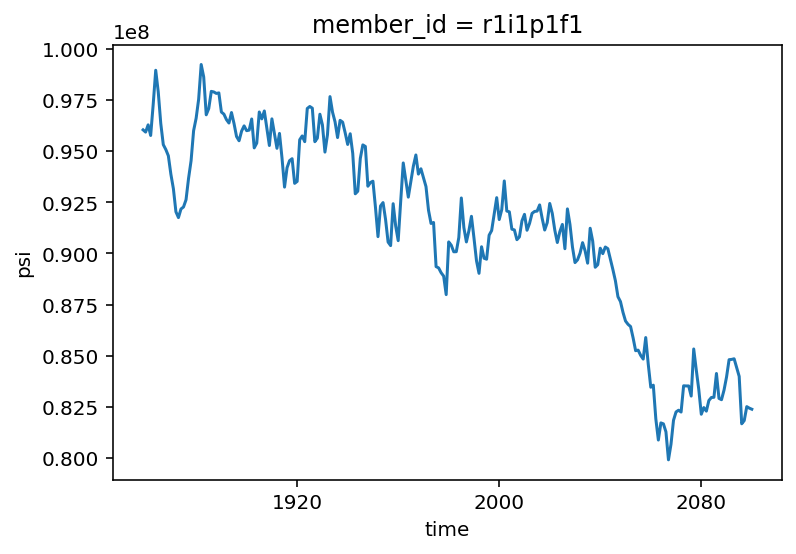

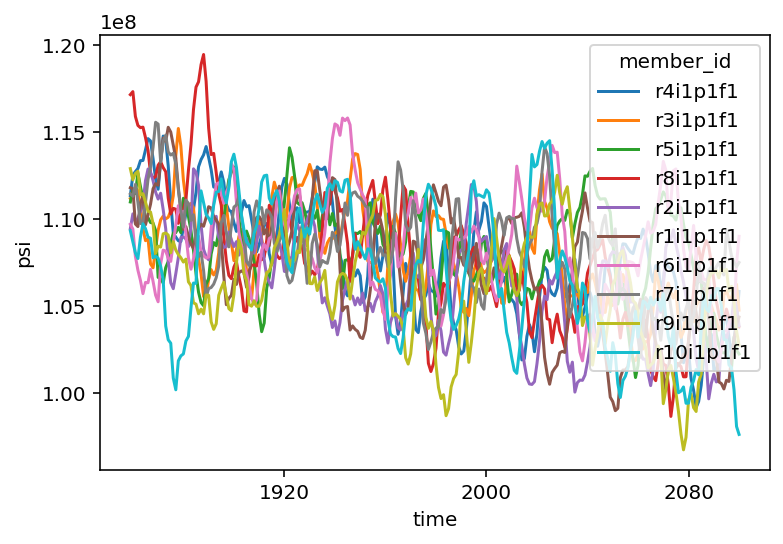

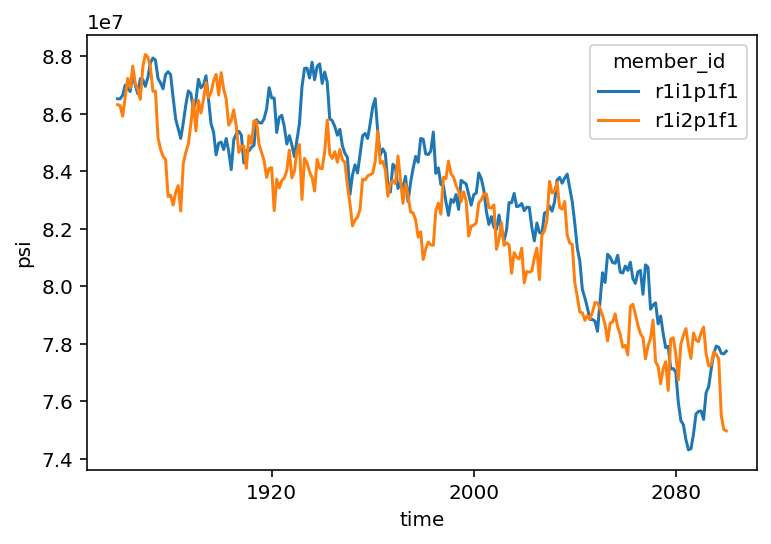

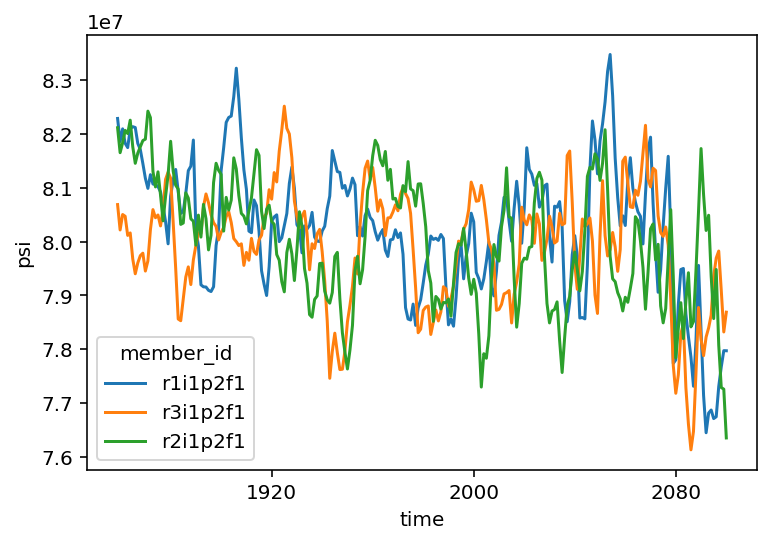

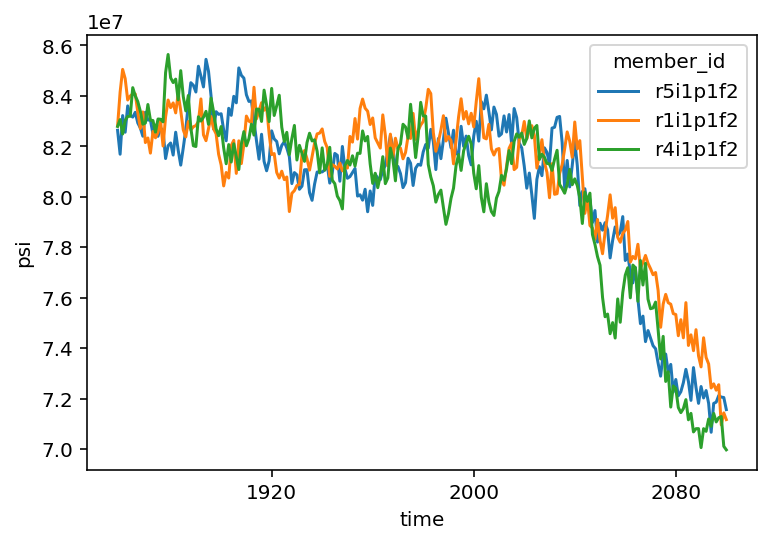

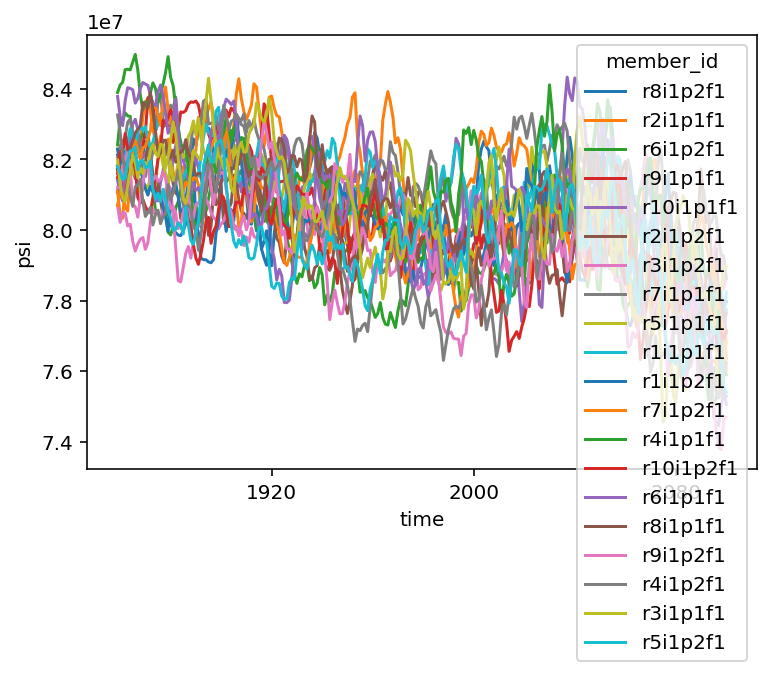

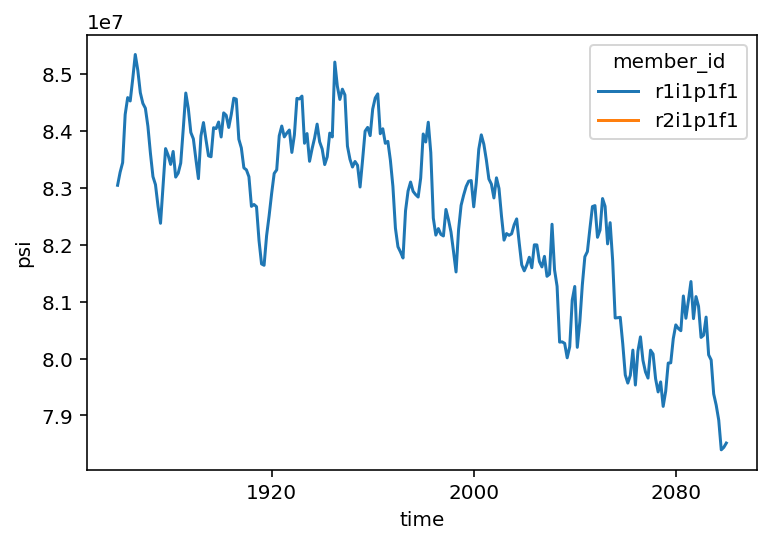

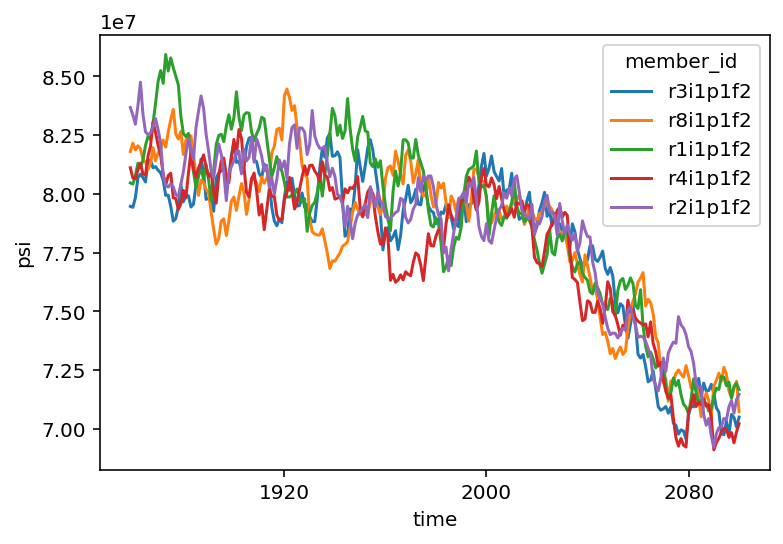

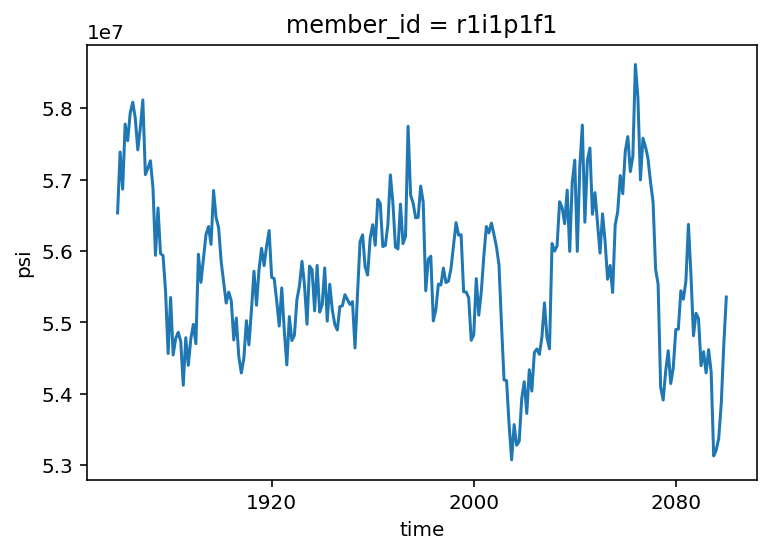

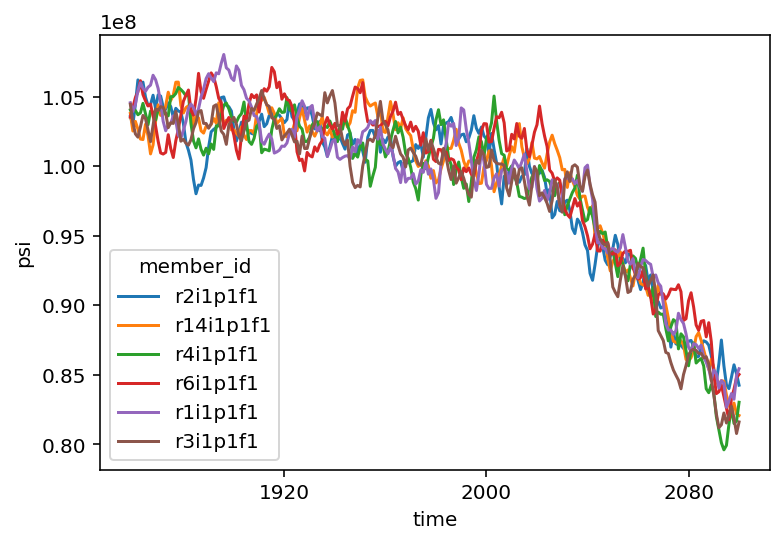

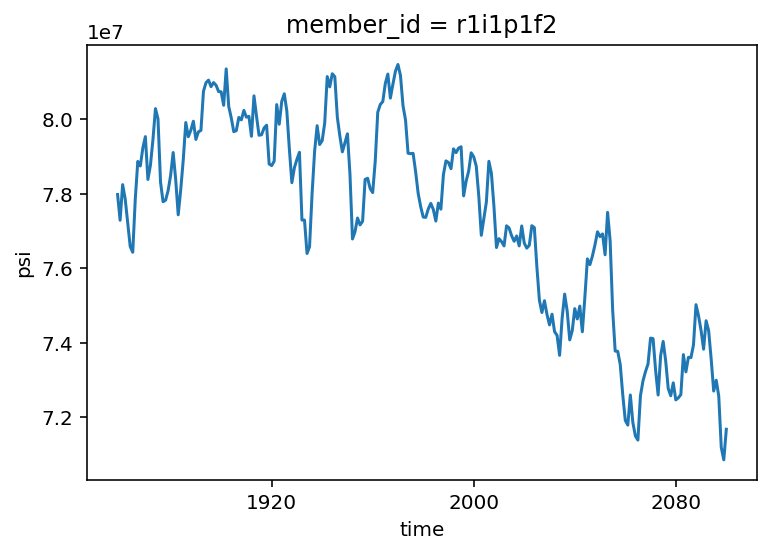

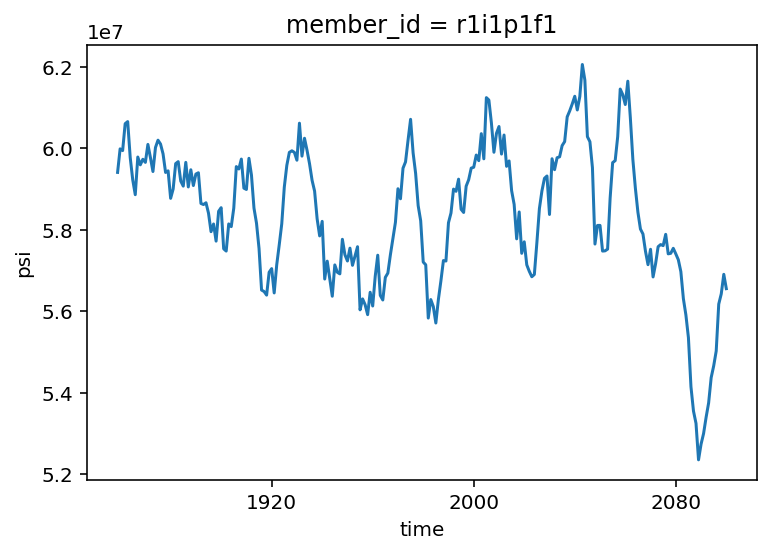

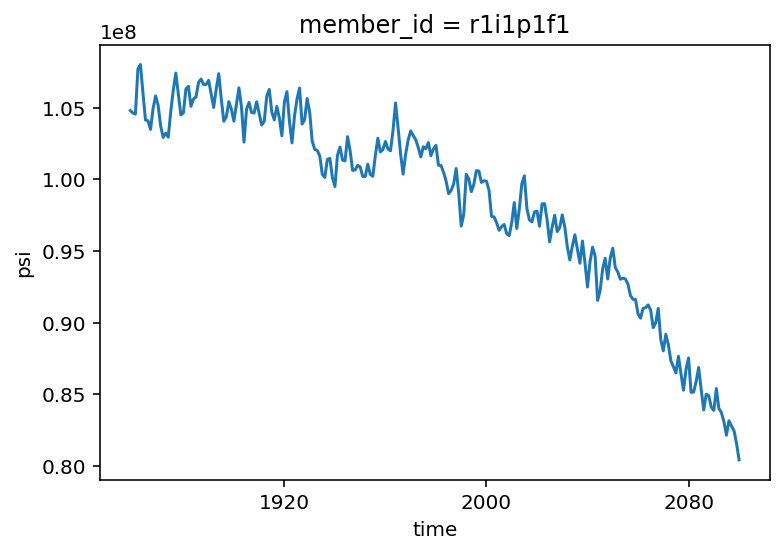

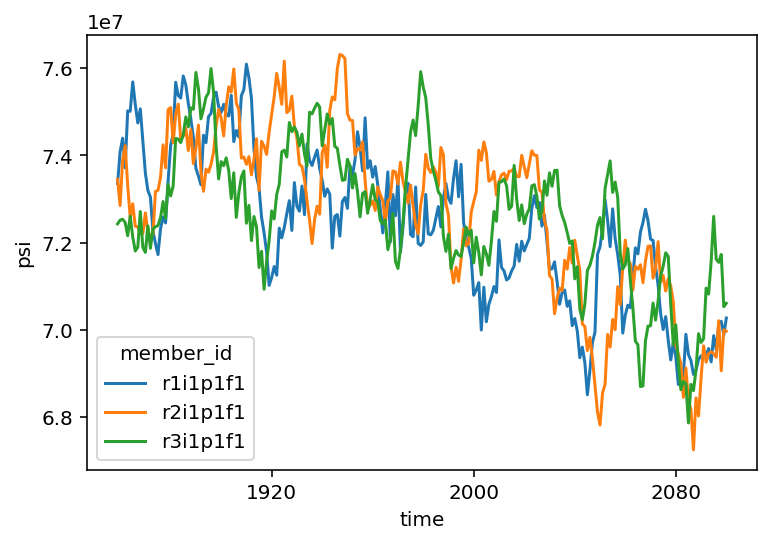

In [21]:
for k,ds in ddict_psi.items():
    plt.figure()
    da = stci(ds)
    da = da.where((da>0).all('time'))
    
    da.rolling(time=10).mean().plot(hue='member_id')
    

In [26]:
basin_bins = ['North Pacific Ocean','South Pacific Ocean']
lat_bins = slice(-30, 30)

hist_slice = slice('1950', '2000')
trend_slice = slice('2000', '2100')

def slope(da):
    assert len(da.time) < 300 # make sure the data is annual
    slope_slice = da.sel(time=trend_slice)
    print('times in trend', len(slope_slice.time))
    return linear_trend(slope_slice, 'time').slope * 100

CanESM5
times in trend 101
times in trend 101
UKESM1-0-LL
times in trend 101
times in trend 101
MIROC-ES2L
times in trend 101
times in trend 101
IPSL-CM6A-LR
times in trend 101
times in trend 101
MPI-ESM1-2-LR
times in trend 101
times in trend 101
ACCESS-ESM1-5
times in trend 101
times in trend 101
CNRM-ESM2-1
times in trend 101
times in trend 101
NorESM2-MM
times in trend 101
times in trend 101
MPI-ESM1-2-HR
times in trend 101
times in trend 101
GFDL-ESM4
times in trend 101
times in trend 101
GFDL-CM4
times in trend 101
times in trend 101
NorESM2-LM
times in trend 101
times in trend 101
CanESM5-CanOE
times in trend 101
times in trend 101
MRI-ESM2-0
times in trend 101
times in trend 101


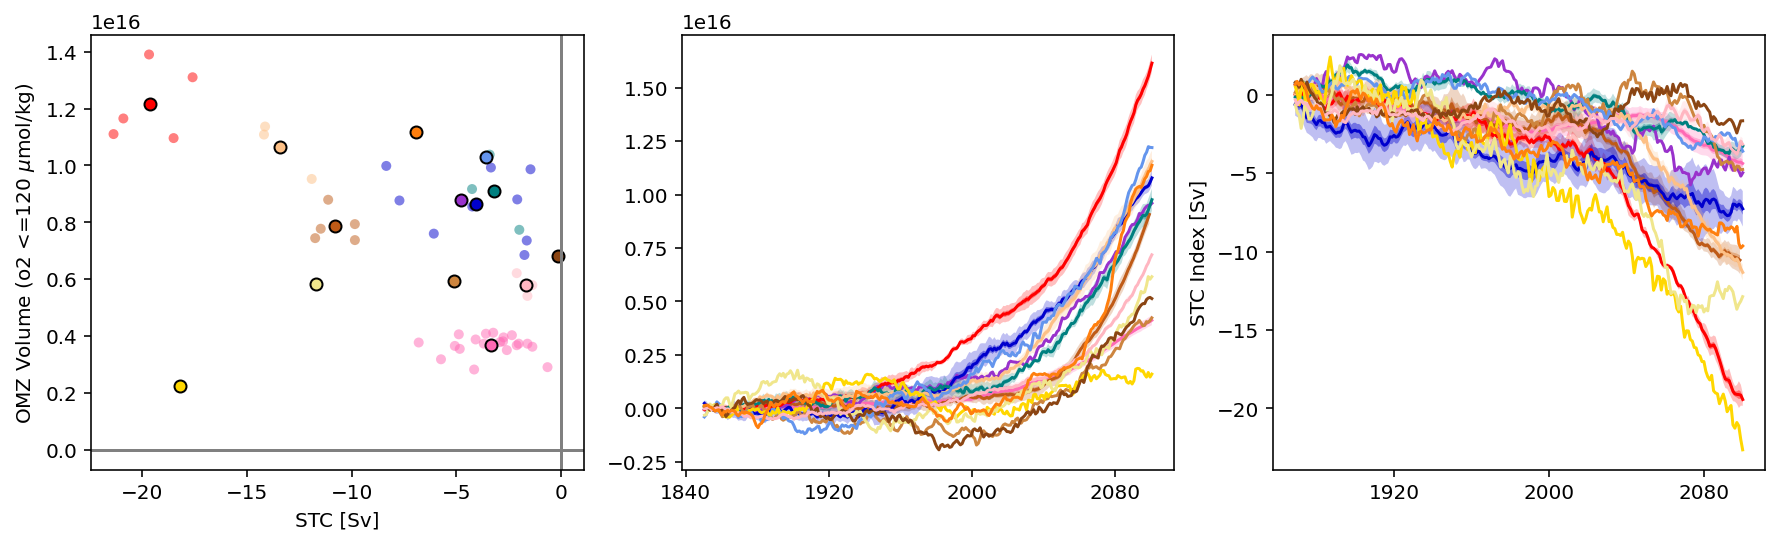

In [55]:
o2=120
fig, (ax_scatter, ax_age, ax_stc) = plt.subplots(ncols=3, figsize=[15,4])
for name in ddict_histogram.keys():
    co = o2_model_colors()[name]

    ds_hist = ddict_histogram[name]

    ds_pre = ds_hist.sel(
        lat_bin=lat_bins,
        basin_mask_bin=basin_bins,
#         lev=slice(0,2000)
    ).sum([
        'lev',
        'lat_bin',
        'basin_mask_bin']
    )

    ds_inner = ds_pre.sel(o2_bin=slice(None, o2)).sum('o2_bin')
    ds_outer = ds_pre.sel(o2_bin=slice(o2, None)).sum('o2_bin')

    ds_psi = ddict_psi[name]

    print(name)
    stc = stci(ds_psi)
    stc = stc.where((stc>0).all('time'))
    stc = stc/1e6 # convert to sverdrup
    vol = ds_inner.volume

    # select only relevant time
    stc = stc.sel(time=slice('1850', '2100')).load()
    vol = vol.sel(time=slice('1850', '2100')).load()

    # align the members
    stc, vol = xr.align(stc, vol, join='inner', exclude='time')

    # print anomaly from historical
    stc_anom = stc-stc.isel(time=slice(0,10)).mean('time')
    vol_anom = vol-vol.isel(time=slice(0,10)).mean('time')

    # smooth stc extra for plotting?
    stc_anom = stc_anom.rolling(time=20).mean()
    
    shaded_line_plot(stc_anom, 'member_id', ax=ax_stc, line_kwargs=dict(color=co))
    shaded_line_plot(vol_anom, 'member_id', ax=ax_age, line_kwargs=dict(color=co))
    
    x = stc
    y = vol
    
    x = slope(x)#/x.sel(time=hist_slice).mean('time')*100
    y = slope(y)#/y.sel(time=hist_slice).mean('time')*100

    ax_scatter.scatter(x.data, y.data, color=co, edgecolor='none', alpha=0.5, s=25)
    ax_scatter.scatter(x.mean('member_id').data, y.mean('member_id').data, color=co, edgecolor='k')
    ax_scatter.set_ylabel(f'OMZ Volume (o2 <={120} $\mu$mol/kg)')
    ax_scatter.set_xlabel('STC [Sv]')

    ax_scatter.axhline(0, color='0.5')
    ax_scatter.axvline(0, color='0.5')
    
    ax_stc.set_ylabel('STC Index [Sv]')
    
fig.savefig(pfolder.joinpath('STC.pdf'))